What does an infinitely wide neural network with batchnorm look like? We will calculate the [Neural Tangent Kernel](https://arxiv.org/abs/1806.07572) of a batchnorm-ReLU Multi-Layer Perceptron in this notebook, according to [our paper](https://arxiv.org/abs/2006.14548), so you can find out yourself!

In [ ]:
!pip install quadpy tqdm

In [1]:
import scipy as sp
import numpy as np
import quadpy as qp
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
from tqdm import tqdm
sns.set()

In [2]:
from utils import Gmatrix, J1, VReLU, VStep, thVReLU, clone_grads, paramdot, flatten

We will consider batchnorm with $B$ batch elements.
Let $x_1, \ldots, x_B \in \mathbb{R}^d$ be a batch of inputs.
Let $\widetilde{\mathrm{relu}}: \mathbb R^B \to \mathbb R^B$ denote batchnorm followed by ReLU.

$$\widetilde{\mathrm{relu}}(z) = \mathrm{relu}\left(\frac{z - \mu}{\sigma}\right),\quad
\text{where $\mu = \frac 1 B \sum_{i=1}^B z_i$ and $\sigma^2 = \frac 1 B \sum_{i=1}^B (z_i - \mu)^2$}$$

<img src="images/batchnormMLP.png" width=600 />

# Finite-Width Neural Network

In [3]:
class MyNet(nn.Module):
    def __init__(self, nonlin=nn.ReLU, width=500, depth=2, inputdim=None, eps=0, initstyle='standard'):
        super(MyNet, self).__init__()
        self.nonlin = nonlin
        self.width = width
        self.depth = depth
        self.params = nn.ParameterList()
        self.BNs = nn.ModuleList()
        self.nonlins = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                if inputdim is None:
                    inputdim = width
                if initstyle == 'standard':
                    w = nn.Parameter(torch.randn(width, inputdim) / np.sqrt(inputdim))
                                 
                else:
                    w = nn.Parameter(torch.randn(width, inputdim))
            else:
                if initstyle == 'standard':
                    w = nn.Parameter(torch.randn(width, width) / np.sqrt(width))
                else:
                    w = nn.Parameter(torch.randn(width, width))
            self.params.append(w)
            self.BNs.append(nn.BatchNorm1d(width, eps=eps, momentum=None, affine=False, track_running_stats=False))
            self.nonlins.append(nonlin())
        self.readout = nn.Parameter(torch.randn(width))
        self.xs = []
        self.hs = []
    def forward(self, x):
        for i in range(self.depth):
            w = self.params[i]
            h = torch.einsum('ij,kj->ki', w, x)
            h.retain_grad()
            x = self.nonlins[i](self.BNs[i](h))
            self.hs.append(h)
            self.xs.append(x)
        return x @ self.readout / np.sqrt(self.width)

# Infinite-Width Neural Network

We first detail how to propagate the covariances of activations and of gradients before describing how we can combine them to compute the NTK.

## Single Batch Forward Propagation

<img src="images/BN_forward_singlebatch.png" width=600 />

We evaluate this integral by 1) reparametrizing exponentially and 2) eigendecomposition to be more efficient. See [this notebook for explanation](https://github.com/thegregyang/GP4A).

In [4]:
def VBNReLUIntegrandExp(Sigma):
    '''Returns the integrand function of VBNRelU(Sigma), reparametrized exponentially
    '''
    B = Sigma.shape[0]
    G = Gmatrix(B)
    eigvals, eigvecs = np.linalg.eigh(G @ Sigma @ G)
    # remove the 1st (smallest) eigenvalue, which is 0
    logeigvals = np.log(eigvals[1:])
    eigvecs = eigvecs[:, 1:]
    def f(logs, logmultfactor=0, eps=1e-10):
        # Ueigvals.shape = [..., B]
        logUeigvals = np.logaddexp(0, np.log(2) + logs[..., None] + logeigvals)
        # inteigvals.shape = [..., B]
        loginteigvals = logeigvals - logUeigvals
        # divide by sqrt(det)
        loginteigvals -= 0.5 * np.sum(logUeigvals, axis=-1, keepdims=True)
        loginteigvals += logmultfactor
        inteigvals = np.exp(loginteigvals)
        return VReLU(np.einsum('ij,...j,jk->...ik', eigvecs, inteigvals, eigvecs.T), eps)
    return f
def VBNReLU(Sigma, npos=10, nneg=10, alpha=1/8):
    '''Computes BN+ReLU kernel for a single batch.
    Inputs:
        Sigma: input kernel (shape = batchsize x batchsize)
        npos: number of points for integrating the big s side of the VBNReLU integral
        nneg: number of points for integrating the small s side of the VBNReLU integral
        alpha: reparametrize the integral by s = exp(alpha r)
    Outputs:
        VBNReLU(Sigma)
    '''
    schemepos = qp.e1r.gauss_laguerre(npos, alpha=0)
    schemeneg = qp.e1r.gauss_laguerre(nneg, alpha=0)
#     intargmax = VBNReLUIntegrandExpArgmax(Sigma).root
    intargmax = 0
    dim = Sigma.shape[0]
    f = VBNReLUIntegrandExp(Sigma)
    integrandpos = lambda xs: np.rollaxis(
        np.rollaxis(
            alpha * f(intargmax + alpha * xs,
                logmultfactor=(intargmax + (1 + alpha) * xs)[..., None]),
            2, 0),
        3, 1)
    integrandneg = lambda xs: np.rollaxis(
        np.exp(intargmax) * np.rollaxis(f(intargmax - xs),
            2, 0),
        3, 1)
    return dim * (
        schemepos.integrate(integrandpos) + schemeneg.integrate(integrandneg)).squeeze(-1)


## Single Batch Backward Propagation

<img src="images/BN_backward_singlebatch1.png" width=600 />

<img src="images/BN_backward_singlebatch2.png" width=600 />

In [5]:
def VBNReLUBackIntegrandExp(Sigma, Delta):
    '''Returns the integrand function of VBNRelUBack(Sigma, Delta), reparametrized exponentially
    '''
    B = Sigma.shape[0]
    G = Gmatrix(B)
    eigvals, eigvecs = np.linalg.eigh(G @ Sigma @ G)
    # remove the 1st (smallest) eigenvalue, which is 0
    logeigvals = np.log(eigvals[1:])
    eigvecs = eigvecs[:, 1:]
    def f(logs, logmultfactor=0, eps=1e-10):
        # Ueigvals.shape = [..., B]
        logUeigvals = np.logaddexp(0, np.log(2) + logs[..., None] + logeigvals)
        # inteigvals.shape = [..., B]
        loginteigvals = logeigvals - logUeigvals
        inteigvals = np.exp(loginteigvals)
        K = np.einsum('ij,...j,jk->...ik', eigvecs, inteigvals, eigvecs.T)
        
        thK = torch.from_numpy(K)
        thK.requires_grad = True
        thReluK = thVReLU(thK, eps)
        reluK = thReluK.data.numpy()
        stepK = VStep(K)
        
        DeltaNewAx = torch.from_numpy(Delta)
        DeltaNewAx = torch.broadcast_tensors(DeltaNewAx, thReluK)[0]
        thReluK.backward(DeltaNewAx)
        # shape [..., B, B]
        J = thK.grad.numpy()
        
        Lambda1 = Delta * stepK
        
        # TODO possible speedup if reuse KJ to compute KJK
        Lambda2 = 0.5 * np.exp(2 * logs)[..., None, None] * (
            K * np.einsum('ij,...ij->...', Delta, reluK)[..., None, None]
            + 2 * np.einsum('...ij,...jk,...kl->...il', K, J, K))
        
        Lambda3 = np.exp(logs)[..., None, None] * \
            np.einsum('...ij,...jk->...ik', K, J)
        Lambda3 = Lambda3 + np.einsum('...ij->...ji', Lambda3)
        
        Lambda = Lambda1 + Lambda2 - Lambda3

        # explicitly multiply by B and conjugate by G outside this fun
        integrand = Lambda * np.exp(
            # divide by sqrt(det)
            logmultfactor - 0.5 * np.sum(logUeigvals, axis=-1, keepdims=True)
        )[..., None]
        
        return integrand
    return f

def VBNReLUBack(Sigma, Delta, npos=10, nneg=10, alpha=1/4):
    '''Computes Jacobian(BN+ReLU) kernel for a single batch.
    Inputs:
        Sigma: input kernel (shape = batchsize x batchsize)
        Delta: gradient kernel (shape = batchsize x batchsize)
        npos: number of points for integrating the big s side of the VBNReLU integral
        nneg: number of points for integrating the small s side of the VBNReLU integral
        alpha: reparametrize the integral by s = exp(alpha r)
    Outputs:
        VBNReLUBack(Sigma){Delta}
    '''
    schemepos = qp.e1r.gauss_laguerre(npos, alpha=0)
    schemeneg = qp.e1r.gauss_laguerre(nneg, alpha=0)
    intargmax = 0
    dim = Sigma.shape[0]
    f = VBNReLUBackIntegrandExp(Sigma, Delta)
    integrandpos = lambda xs: np.rollaxis(
        np.rollaxis(
            alpha * f(intargmax + alpha * xs,
                logmultfactor=(intargmax + (1 + alpha) * xs)[..., None]),
            2, 0),
        3, 1)
    integrandneg = lambda xs: np.rollaxis(
        np.exp(intargmax) * np.rollaxis(f(intargmax - xs),
            2, 0),
        3, 1)
    out = dim * (
        schemepos.integrate(integrandpos) + schemeneg.integrate(integrandneg)).squeeze(-1)
    G = Gmatrix(dim)
    return G @ out @ G

## Cross Batch Forward Propagation

<img src="images/BN_forward_crossbatch.png" width=600 />

Again, we evaluate this integral by 1) reparametrizing exponentially and 2) eigendecomposition to be more efficient. See [this notebook for explanation](https://github.com/thegregyang/GP4A).

In [6]:
def VBNReLUCrossBatchIntegrand(Xi, Sigma1, Sigma2):
    '''Computes the off diagonal block of the BN+ReLU kernel over 2 batches
    Input:
        Xi: covariance between batch1 and batch2
        Sigma1: autocovariance of batch1
        Sigma2: autocovariance of batch2
    Output:
        f: integrand function in the integral for computing cross batch VBNReLU 
    '''
    n1 = Sigma1.shape[0]
    n2 = Sigma2.shape[0]
    G1 = Gmatrix(n1)
    G2 = Gmatrix(n2)
    Delta1, A1 = np.linalg.eigh(G1 @ Sigma1 @ G1)
    Delta2, A2 = np.linalg.eigh(G2 @ Sigma2 @ G2)
    # kill first 0 eigenval
    Delta1 = Delta1[1:]
    Delta2 = Delta2[1:]
    A1 = A1[:, 1:]
    A2 = A2[:, 1:]
    
    Xidot = A1.T @ Xi @ A2
    Omegadot = np.block([[np.diag(Delta1), Xidot], [Xidot.T, np.diag(Delta2)]])
    Omegadotinv = np.linalg.inv(Omegadot)
    
    def f(s, t, multfactor=1):
        # Ddot.shape = (..., n1+n2-2, n1+n2-2)
        Ddot = s[..., None, None] * np.eye(n1-1+n2-1)
        Ddot[..., np.arange(n1-1, n1+n2-2), np.arange(n1-1, n1+n2-2)] = t[..., None]
        
        ## Compute off-diagonal block of VReLU(Pi)
        Pitilde = Omegadotinv + 2 * Ddot
        Pitilde = np.linalg.inv(Pitilde)
        Pi11diag = np.einsum('ij,...jk,ki->...i',
                            A1,
                            Pitilde[..., :n1-1, :n1-1],
                            A1.T)
        Pi22diag = np.einsum('ij,...jk,ki->...i',
                            A2,
                            Pitilde[..., n1-1:, n1-1:],
                            A2.T)
        Pi12 = np.einsum('ij,...jk,kl->...il',
                        A1,
                        Pitilde[..., :n1-1, n1-1:],
                        A2.T)
        C = J1(np.einsum('...i,...ij,...j->...ij',
                        Pi11diag**-0.5,
                        Pi12,
                        Pi22diag**-0.5))
        VReLUPi12 = 0.5 * np.einsum('...i,...ij,...j->...ij',
                                Pi11diag**0.5,
                                C,
                                Pi22diag**0.5)
        
        ## Compute determinant
        ind = np.arange(n1+n2-2)
        # Ddot <- matrix inverse of Ddot
        Ddot[..., ind, ind] = Ddot[..., ind, ind]**-1
        logdet = np.linalg.slogdet(Ddot + 2 * Omegadot)[1]
        return np.exp(
                    (np.log(multfactor)
                      + (-n1/2) * np.log(s)
                      + (-n2/2) * np.log(t)
                      - 1/2 * logdet)[..., None, None] + np.log(VReLUPi12))
    return f

def VBNReLUCrossBatch(Xi, Sigma1, Sigma2, npos=10, nneg=5,
                      alphapos1=1/3, alphaneg1=1,
                     alphapos2=1/3, alphaneg2=1):
    '''Compute VBNReLU for two batches.
    
    Inputs:
        Xi: covariance between batch1 and batch2
        Sigma1: autocovariance of batch1
        Sigma2: autocovariance of batch2
        npos: number of points for integrating the big s side of the VBNReLU integral
            (effective for both dimensions of integration)
        nneg: number of points for integrating the small s side of the VBNReLU integral
            (effective for both dimensions of integration)
        alphapos1: reparametrize the large s integral by s = exp(alpha r) in the 1st dimension
        alphaneg1: reparametrize the small s integral by s = exp(alpha r) in the 1st dimension
        alphapos2: reparametrize the large s integral by s = exp(alpha r) in the 2nd dimension
        alphaneg2: reparametrize the small s integral by s = exp(alpha r) in the 2nd dimension
            By tuning the `alpha` parameters, the integrand is closer to being well-approximated by 
            low-degree Laguerre polynomials, which makes the quadrature more accurate in approximating the integral.
    Outputs:
        The (batch1, batch2) block of block matrix obtained by
        applying VBNReLU^{\oplus 2} to the kernel of batch1 and batch2
    '''
    # We will do the integration explicitly ourselves:
    #     We obtain sample points and weights via `quadpy`'s Gauss Laguerre quadrature
    #     and do the sum ourselves
    schemepos = qp.e1r.gauss_laguerre(npos, alpha=0)
    schemeneg = qp.e1r.gauss_laguerre(nneg, alpha=0)
    dim1 = Sigma1.shape[0]
    dim2 = Sigma2.shape[0]
    intargmax = (-np.log(2*(dim1-1)), -np.log(2*(dim2-1)))
    f = VBNReLUCrossBatchIntegrand(Xi, Sigma1, Sigma2)
    # Get the points manually for each dimension
    scheme1dpoints = np.concatenate([schemepos.points, -schemeneg.points])
    # Get the weights manually for each dimension
    scheme1dwts = np.concatenate([schemepos.weights, schemeneg.weights])
    # Obtain the points for the whole 2d integration
    scheme2dpoints = np.meshgrid(scheme1dpoints, scheme1dpoints)
    # Obtain the weights for the whole 2d integration
    scheme2dwts = scheme1dwts[:, None] * scheme1dwts[None, :]

    def applyalpha(x, alphapos, alphaneg):
        xx = np.copy(x)
        xx[xx > 0] *= alphapos
        xx[xx <= 0] *= alphaneg
        return xx
    def alphafactor(x, y):
        a = np.zeros_like(x)
        a[(x > 0) & (y > 0)] = alphapos1 * alphapos2
        a[(x > 0) & (y <= 0)] = alphapos1 * alphaneg2
        a[(x <= 0) & (y > 0)] = alphaneg1 * alphapos2
        a[(x <= 0) & (y <= 0)] = alphaneg1 * alphaneg2
        return a
        
    integrand = lambda inp: \
        f(np.exp(applyalpha(inp[0], alphapos1, alphaneg1) + intargmax[0]), 
          np.exp(applyalpha(inp[1], alphapos2, alphaneg2) + intargmax[1]),
          multfactor=alphafactor(inp[0], inp[1])
              * np.pi**-1
              * np.exp(applyalpha(inp[0], alphapos1, alphaneg1) + intargmax[0]
                     + applyalpha(inp[1], alphapos2, alphaneg2) + intargmax[1]
                     + np.abs(inp[0]) + np.abs(inp[1])
                      )
         )

    return np.sqrt(dim1 * dim2) * np.einsum('ij...,ij->...',
              integrand(scheme2dpoints),
              scheme2dwts
             )


## Cross Batch Backward Propagation

<img src="images/BN_backward_crossbatch.png" width=600 />

In [7]:
def VBNReLUBackCrossBatchIntegrand(Xi, Sigma1, Sigma2, Chi):
    '''Computes the off diagonal block of the Jacobian(BN+ReLU) kernel over 2 batches
    Input:
        Xi: covariance between batch1 and batch2
        Sigma1: autocovariance of batch1
        Sigma2: autocovariance of batch2
        Chi: covariance of gradients btw batch1 and batch2
    Output:
        f: integrand function in the integral for computing cross batch VBNReLUBack
    '''
    n1 = Sigma1.shape[0]
    n2 = Sigma2.shape[0]
    G1 = Gmatrix(n1)
    G2 = Gmatrix(n2)
    Delta1, A1 = np.linalg.eigh(G1 @ Sigma1 @ G1)
    Delta2, A2 = np.linalg.eigh(G2 @ Sigma2 @ G2)
    # kill first 0 eigenval
    Delta1 = Delta1[1:]
    Delta2 = Delta2[1:]
    A1 = A1[:, 1:]
    A2 = A2[:, 1:]
    A = np.block([[A1, np.zeros([n1, n2-1])], [np.zeros([n2, n1-1]), A2]])
    ChiSym = np.block([[np.zeros([n1, n1]), Chi],
                       [Chi.T, np.zeros([n2, n2])]])
    
    Xidot = A1.T @ Xi @ A2
    Omegadot = np.block([[np.diag(Delta1), Xidot], [Xidot.T, np.diag(Delta2)]])
    Omegadotinv = np.linalg.inv(Omegadot)
    
    def f(s, t, multfactor=1):
        ss = s[..., None, None]
        tt = t[..., None, None]
        # Ddot.shape = (..., n1+n2-2, n1+n2-2)
        Ddot = ss * np.eye(n1-1+n2-1)
        Ddot[..., np.arange(n1-1, n1+n2-2), np.arange(n1-1, n1+n2-2)] = t[..., None]
        
        ## Compute off-diagonal block of VReLU(Pi)
        Pitilde = Omegadotinv + 2 * Ddot
        Pitilde = np.linalg.inv(Pitilde)
        Pi = np.einsum('ij,...jk,kl->...il', A, Pitilde, A.T)
        
        stepPi = VStep(Pi)
        thPi = torch.from_numpy(Pi)
        thPi.requires_grad = True
        thReluPi = thVReLU(thPi)
        # shape (..., n1+n2, n1+n2)
        reluPi = thReluPi.detach().numpy()
        thChiSym = torch.from_numpy(ChiSym)
        thChiSym = torch.broadcast_tensors(thChiSym, thReluPi)
        thReluPi.backward(thChiSym)
        # shape (..., n1+n2, n1+n2)
        J = thPi.grad.numpy()

        Gamma1 = Chi * stepPi[..., :n1, n1:]
        
        # < reluPi, ChiSym > * Pi
        Gamma2a = 2 * np.einsum(
            '...ij,ij,...kl->...kl',
            reluPi[..., :n1, n1:], Chi, Pi[..., :n1, n1:]
        )
        Gamma2b = 2 * np.einsum(
            '...ij,...jk,...kl->...il',
            Pi, J, Pi
        )
        Gamma2b = Gamma2b[..., :n1, n1:]
        Gamma2 = 2 * ss * tt * (Gamma2a + Gamma2b)
        
        # t * J * Pi
        JPi = np.einsum(
            '...ij,...jk->...ik',
            J, Pi
        )
        Gamma3 = tt * JPi[..., :n1, n1:] + \
                ss * np.einsum(
                    '...ij->...ji',
                    JPi[..., n1:, :n1]
                )
        Gamma3 *= 2
        
        Gamma = Gamma1 + Gamma2 - Gamma3
        
        ## Compute determinant
        ind = np.arange(n1+n2-2)
        # Ddot <- matrix inverse of Ddot
        Ddot[..., ind, ind] = Ddot[..., ind, ind]**-1
        logdet = np.linalg.slogdet(Ddot + 2 * Omegadot)[1]
        return np.exp(
                    (np.log(multfactor)
                      + (-n1/2) * np.log(s)
                      + (-n2/2) * np.log(t)
                      - 1/2 * logdet)[..., None, None]) \
            * Gamma
    return f

def VBNReLUBackCrossBatch(Xi, Sigma1, Sigma2, Chi, npos=10, nneg=5,
                      alphapos1=1/3, alphaneg1=1,
                     alphapos2=1/3, alphaneg2=1):
    '''Compute the Jacobian(BN+ReLU) kernel for covariance btw two batches.
    
    Inputs:
        Xi: covariance between batch1 and batch2
        Sigma1: autocovariance of batch1
        Sigma2: autocovariance of batch2
        Chi: covariance of gradients btw batch1 and batch2
        npos: number of points for integrating the big s side of the VBNReLU integral
            (effective for both dimensions of integration)
        nneg: number of points for integrating the small s side of the VBNReLU integral
            (effective for both dimensions of integration)
        alphapos1: reparametrize the large s integral by s = exp(alpha r) in the 1st dimension
        alphaneg1: reparametrize the small s integral by s = exp(alpha r) in the 1st dimension
        alphapos2: reparametrize the large s integral by s = exp(alpha r) in the 2nd dimension
        alphaneg2: reparametrize the small s integral by s = exp(alpha r) in the 2nd dimension
            By tuning the `alpha` parameters, the integrand is closer to being well-approximated by 
            low-degree Laguerre polynomials, which makes the quadrature more accurate in approximating the integral.
    Outputs:
        array of shape (batchsize1, batchsize2) that describes
        the covariance of the gradients btw batch1 and batch2
        after backprop through BN+ReLU
    '''
    # We will do the integration explicitly ourselves:
    #     We obtain sample points and weights via `quadpy`'s Gauss Laguerre quadrature
    #     and do the sum ourselves
    schemepos = qp.e1r.gauss_laguerre(npos, alpha=0)
    schemeneg = qp.e1r.gauss_laguerre(nneg, alpha=0)
    dim1 = Sigma1.shape[0]
    dim2 = Sigma2.shape[0]
    intargmax = (-np.log(2*(dim1-1)), -np.log(2*(dim2-1)))
    f = VBNReLUBackCrossBatchIntegrand(Xi, Sigma1, Sigma2, Chi)
    # Get the points manually for each dimension
    scheme1dpoints = np.concatenate([schemepos.points, -schemeneg.points])
    # Get the weights manually for each dimension
    scheme1dwts = np.concatenate([schemepos.weights, schemeneg.weights])
    # Obtain the points for the whole 2d integration
    scheme2dpoints = np.meshgrid(scheme1dpoints, scheme1dpoints)
    # Obtain the weights for the whole 2d integration
    scheme2dwts = scheme1dwts[:, None] * scheme1dwts[None, :]

    def applyalpha(x, alphapos, alphaneg):
        xx = np.copy(x)
        xx[xx > 0] *= alphapos
        xx[xx <= 0] *= alphaneg
        return xx
    def alphafactor(x, y):
        a = np.zeros_like(x)
        a[(x > 0) & (y > 0)] = alphapos1 * alphapos2
        a[(x > 0) & (y <= 0)] = alphapos1 * alphaneg2
        a[(x <= 0) & (y > 0)] = alphaneg1 * alphapos2
        a[(x <= 0) & (y <= 0)] = alphaneg1 * alphaneg2
        return a
        
    integrand = lambda inp: \
        f(np.exp(applyalpha(inp[0], alphapos1, alphaneg1) + intargmax[0]), 
          np.exp(applyalpha(inp[1], alphapos2, alphaneg2) + intargmax[1]),
          multfactor=alphafactor(inp[0], inp[1])
              * np.pi**-1
              * np.exp(applyalpha(inp[0], alphapos1, alphaneg1) + intargmax[0]
                     + applyalpha(inp[1], alphapos2, alphaneg2) + intargmax[1]
                     + np.abs(inp[0]) + np.abs(inp[1])
                      )
         )

    out = np.sqrt(dim1 * dim2) * np.einsum('ij...,ij->...',
              integrand(scheme2dpoints),
              scheme2dwts
             )
    G1 = Gmatrix(dim1)
    G2 = Gmatrix(dim2)
    return G1 @ out @ G2

## NTK

<img src="images/BN_NTK_singlebatch.png" width=600 />

<img src="images/BN_NTK_crossbatch.png" width=600 />

In [8]:
def theorykernels(mykerx, myker1, myker2, depth):
    n1 = myker1.shape[0]
    n2 = myker2.shape[0]
    
    ker1s = [myker1]
    ker2s = [myker2]
    kerxs = [mykerx]
    for i in range(depth):
        kerxs.append(VBNReLUCrossBatch(kerxs[-1], ker1s[-1], ker2s[-1]))
        ker1s.append(VBNReLU(ker1s[-1]))
        ker2s.append(VBNReLU(ker2s[-1]))
        
    def make_single_batch_ntk(kers):
        n = kers[0].shape[0]
        ntk = np.zeros([n, n])
        for i in range(n):
            for j in range(i+1):
                Deltas = [np.zeros([n, n])]
                Deltas[-1][i, j] = Deltas[-1][j, i] = 1
                if i != j:
                    Deltas[-1] /= 2
                for l in range(depth):
                    Deltas.append(
                        VBNReLUBack(kers[depth-l-1], Deltas[-1])
                    )
                for l in range(len(kers)):
                    ntk[i, j] += (kers[l].reshape(-1)
                                   @ Deltas[-1-l].reshape(-1))
                ntk[j, i] = ntk[i, j]
        return ntk
    
    ntk1 = make_single_batch_ntk(ker1s)
    ntk2 = make_single_batch_ntk(ker2s)
    
    ntkx = np.zeros([n1, n2])
    for i in range(n1):
        for j in range(n2):
            Deltas = [np.zeros([n1, n2])]
            Deltas[-1][i, j] = 1
            for l in range(depth):
                Deltas.append(
                    VBNReLUBackCrossBatch(
                        kerxs[depth-l-1], ker1s[depth-l-1], ker2s[depth-l-1],
                        Deltas[-1])
                )
            for l in range(len(kerxs)):
                ntkx[i, j] += (kerxs[l].reshape(-1)
                               @ Deltas[-1-l].reshape(-1))
        
    return dict(
        ker1s=ker1s,
        ker2s=ker2s,
        kerxs=kerxs,
        ntk1=ntk1,
        ntk2=ntk2,
        ntkx=ntkx
    )

# Theory vs Simulation

We verify that as width increases, the empirical finite-width NTK converges to the theoretical infinite-width NTK.

## Code

In [9]:
def simkernels(myinp1, myinp2, mynet):
    mynet.zero_grad()
    mynet.hs = []
    out2 = mynet(myinp2)
    out2.backward(torch.ones_like(out2))
    gg2 = mynet.hs[0].grad.clone()

    mynet.zero_grad()
    mynet.hs = []
    out1 = mynet(myinp1)
    out1.backward(torch.ones_like(out1))
    gg1 = mynet.hs[0].grad.clone()


    hdelta1 = gg1 @ gg1.T # / gg1.shape[1]
    hdelta2 = gg2 @ gg2.T # / gg1.shape[1]
    hdeltax = gg1 @ gg2.T # / gg1.shape[1]
    return [c.detach().numpy() for c in [hdeltax, hdelta1, hdelta2]]

In [10]:
def simNTK(myinp1, myinp2, mynet):
    n1 = myinp1.shape[0]
    n2 = myinp2.shape[0]
    
    if isinstance(myinp1, np.ndarray):
        myinp1 = torch.from_numpy(myinp1).float()
    if isinstance(myinp2, np.ndarray):
        myinp2 = torch.from_numpy(myinp2).float()
    
    ggs = []
    for batch in [myinp1, myinp2]:
        gs = []
        mynet.zero_grad()
        out = mynet(batch)
        for i in range(len(batch)):
            mynet.zero_grad()
            outgrad = torch.zeros_like(out)
            outgrad[i] = 1
            out.backward(outgrad, retain_graph=True)
            g = flatten(clone_grads(mynet))
            gs.append(g)
        ggs.append(torch.stack(gs))
    
    ntk1 = ggs[0] @ ggs[0].T
    ntk2 = ggs[1] @ ggs[1].T
    ntkx = ggs[0] @ ggs[1].T
    
    return [c.detach().numpy() for c in [ntkx, ntk1, ntk2]]

In [11]:
def NTK_theory_vs_sim(myinp1, myinp2, 
                    theorykerx, theoryker1, theoryker2,
                    depth,
                    mode='ntk',
                    log2widthmin=6, log2widthmax=14, nseeds=10):
    if isinstance(myinp1, np.ndarray):
        myinp1 = torch.from_numpy(myinp1).float()
    if isinstance(myinp2, np.ndarray):
        myinp2 = torch.from_numpy(myinp2).float()
    inputdim = myinp1.shape[-1]
    theorynorm1 = np.linalg.norm(theoryker1)
    theorynorm2 = np.linalg.norm(theoryker2)
    theorynormx = np.linalg.norm(theorykerx)
    theorynorm = np.sqrt(theorynorm1**2 + theorynorm2**2 + 2 * theorynormx**2)
    frobs = []
    widths = 2**np.arange(log2widthmin, log2widthmax)
    for width, seed in tqdm(list(product(widths, range(nseeds)))):
        torch.manual_seed(seed)
        mynet = MyNet(depth=depth, inputdim=inputdim, width=width,
                     initstyle=mode.lower())

        if mode.lower() == 'ntk':
            hdeltax, hdelta1, hdelta2 = simNTK(myinp1, myinp2, mynet)
        else:
            hdeltax, hdelta1, hdelta2 = simkernels(myinp1, myinp2, mynet)

        frob1 = np.linalg.norm(hdelta1 - theoryker1)
        frob2 = np.linalg.norm(hdelta2 - theoryker2)
        frobx = np.linalg.norm(hdeltax - theorykerx)
        frob = np.sqrt(frob1**2 + frob2**2 + 2 * frobx**2)

        frobs.append(dict(
            width=width,
            frob1=frob1,
            frob2=frob2,
            frobx=frobx,
            frob=frob,
            relfrob1=frob1/theorynorm1,
            relfrob2=frob2/theorynorm2,
            relfrobx=frobx/theorynormx,
            relfrob=frob/theorynorm,
            theorynorm1=theorynorm1,
            theorynorm2=theorynorm2,
            theorynormx=theorynormx,
        ))
    return pd.DataFrame(frobs)

## Data

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [13]:
nsamples = 12
n1 = 7
n2 = 5
inpdim = nsamples + 1
olddim = 3 * 32 * 32

In [14]:
myimages = list(trainset)[:nsamples]
myimages = np.array([im[0].numpy() for im in myimages])

In [15]:
myimagesproj = myimages.reshape(nsamples, -1) @ \
            np.random.randn(olddim, inpdim) / np.sqrt(olddim)

In [16]:
inker = myimagesproj.reshape(nsamples, -1) @ \
        myimagesproj.reshape(nsamples, -1).T / inpdim

## How much does finite-width NTK deviate from the infinite-width NTK?

In [17]:
depth=1

In [18]:
inf_kers = theorykernels(
    inker[:n1, n1:], inker[:n1, :n1], inker[n1:, n1:], depth=depth)

In [19]:
frob_df = NTK_theory_vs_sim(
    myimagesproj[:n1], myimagesproj[n1:],
    inf_kers['ntkx'], inf_kers['ntk1'], inf_kers['ntk2'],
    depth=depth,
    log2widthmax=14, nseeds=100,
)

100%|██████████| 800/800 [02:09<00:00,  6.18it/s]


We measured the relative Frobenius norm of the finite-width deviation = $\|\Theta - \mathring \Theta\|_F / \|\mathring \Theta\|_F$, where $\Theta$ and $\mathring \Theta$ are resp. the finite (empirical) and infinite-width (theoretical) NTKs.

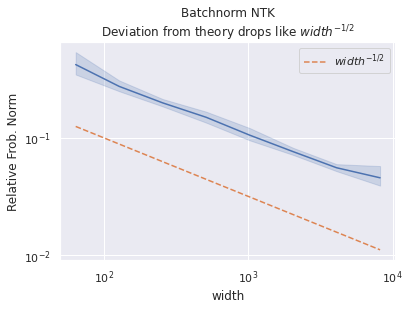

In [20]:
sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'Batchnorm NTK\nDeviation from theory drops like $width^{-1/2}$')

In [21]:
frob_df.to_pickle('batchnorm_ntk.frob')